In [1]:
import os

os.makedirs("/kaggle/working/dl", exist_ok = True)

for fname in [
    "VinaFood.py",
    "Inception_Blocks.py",
    "GoogLeNet.py",
    "main_googlenet.py"
]:
  open(f"/kaggle/working/dl/{fname}", "w").close()

## Câu 2: GoogLeNet

In [2]:
%%writefile /kaggle/working/dl/VinaFood.py
import torch
from torch.utils.data import Dataset
from pathlib import Path # xử lý đường dẫn
from PIL import Image # đọc ảnh
import os

def collate_fn(samples: list[dict]) -> torch.Tensor:
  images = [sample["image"] for sample in samples]
  labels = [sample["label"] for sample in samples]

  images = torch.cat(images, dim = 0) # Ghép các tensor [1, 3, H, W] lại thành [bs, 3, H, W]
  labels = torch.tensor(labels) # Chuyển list các label (số) [0, 1, 2, 0] thành tensor [bs]

  return {
      "image": images,
      "label": labels
  }

class VinaFood(Dataset):
  def __init__(self, image_path: str, transform = None):
    super().__init__()

    self.root_dir = Path(image_path)
    self.transform = transform

    # 1. Lấy danh sách tên thư mục con
    # Sắp xếp thứ tự
    self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])

    # 2. Tạo map từ labels sang số
    self.class_to_idx = {
        cls_name: i for i, cls_name in enumerate(self.classes)
    }

    # 3. Quét toàn bộ thư mục để lấy đường dẫn ảnh và nhãn tương ứng
    self.samples = []

    for class_name in self.classes:
      class_idx = self.class_to_idx[class_name] # lấy số
      class_dir = self.root_dir / class_name

      # Lặp qua các file trong thư mục clas đó
      for img_path in class_dir.iterdir():
        self.samples.append((img_path,class_idx))

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(self, idx) -> dict:
    # Lấy đường dẫn và nhãn qua index
    img_path, label = self.samples[idx]

    # Đọc ảnh
    image = Image.open(img_path).convert("RGB")

    # Áp dụng transform nếu có
    if self.transform:
      image = self.transform(image)

    if isinstance(image, torch.Tensor):
      image = image.unsqueeze(0)

    return {
        "image": image,
        "label": label
    }

Overwriting /kaggle/working/dl/VinaFood.py


In [3]:
%%writefile /kaggle/working/dl/Inception_Blocks.py
import torch
from torch import nn

class Inception_Blocks(nn.Module):
  def __init__(self, in_channels,
               out_1x1,
               out_3x3_reduce, out_3x3,
               out_5x5_reduce, out_5x5,
               out_pool_proj):
      super().__init__()

      # Nhánh trái
      self.branch1 = nn.Sequential(
          nn.Conv2d(in_channels,out_1x1,
          kernel_size = (1,1)),
          nn.ReLU(inplace = True)
          )

      # Nhánh 2: 1x1 Conv (reduce) -> 3x3 Conv
      self.branch2 = nn.Sequential(
          # Lớp 1x1
          nn.Conv2d(in_channels,out_3x3_reduce, kernel_size = (1,1)),
          nn.ReLU(inplace=True),

          # Lớp 3x3
          nn.Conv2d(out_3x3_reduce, out_3x3, kernel_size = (3,3), padding=1),
          nn.ReLU(inplace=True)
      )

      # Nhánh 3: 1x1 Conv (reduce) -> 5x5 Conv
      self.branch3 = nn.Sequential(
          # Lớp 1x1
          nn.Conv2d(in_channels,out_5x5_reduce, kernel_size = (1,1)),
          nn.ReLU(inplace=True),

          # Lớp 5x5
          nn.Conv2d(out_5x5_reduce, out_5x5, kernel_size = (5,5), padding =2),
          nn.ReLU(inplace=True)
      )

      # Nhánh phải
      self.branch4 = nn.Sequential(
          # MaxPool
          nn.MaxPool2d(kernel_size = (3,3), stride=1, padding=1),
          nn.Conv2d(in_channels,out_pool_proj,
          kernel_size = (1,1)),
          nn.ReLU(inplace=True)
          )

  def forward(self, features: torch.Tensor):
    b1_out = self.branch1(features)
    b2_out = self.branch2(features)
    b3_out = self.branch3(features)
    b4_out = self.branch4(features)

    # Gộp các nhánh lại theo chiều channel (dim=1)
    return torch.cat([b1_out, b2_out, b3_out, b4_out], dim=1)

Overwriting /kaggle/working/dl/Inception_Blocks.py


In [4]:
%%writefile /kaggle/working/dl/GoogLeNet.py
import torch
from torch import nn
from Inception_Blocks import Inception_Blocks as ib 

class GoogLeNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    # Các lớp đầu tiên
    self.stem = nn.Sequential(
        # conv (7x7/2, out 64)
        nn.Conv2d(in_channels, 64, kernel_size = (7,7), stride = 2, padding =3),
        nn.ReLU(inplace=True),

        # maxpool (3x3/2)
        nn.MaxPool2d(kernel_size=(3,3), stride = 2),

        # 1x1 (out64) và 3x3 (out192)
        nn.Conv2d(64, 64, kernel_size=1, stride=1), # 1x1 reduce
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 192, kernel_size=(3,3), stride=1, padding=1), # 3x3
        nn.ReLU(inplace=True),

        # Dòng 4: max pool (3x3/2)
        nn.MaxPool2d(kernel_size= (3,3), stride=2, padding=1)
    )
    # Output của stem: [bs, 192, 28, 28]
    # Khối inception
    # in_channels=192
    self.inception_3a = ib(192, 64, 96, 128, 16, 32, 32) # out=256 
    self.inception_3b = ib(256, 128, 128, 192, 32, 96, 64) # out=480 
    self.pool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # Output: [B, 480, 14, 14]

    # in_channels=480
    self.inception_4a = ib(480, 192, 96, 208, 16, 48, 64) # out=512 
    self.inception_4b = ib(512, 160, 112, 224, 24, 64, 64) # out=512 
    self.inception_4c = ib(512, 128, 128, 256, 24, 64, 64) # out=512 
    self.inception_4d = ib(512, 112, 144, 288, 32, 64, 64) # out=528 
    self.inception_4e = ib(528, 256, 160, 320, 32, 128, 128) # out=832 
    self.pool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # Output: [B, 832, 7, 7]

    # in_channels=832
    self.inception_5a = ib(832, 256, 160, 320, 32, 128, 128) # out=832 <-- ĐÃ SỬA
    self.inception_5b = ib(832, 384, 192, 384, 48, 128, 128) # out=1024 <-- ĐÃ SỬA
    # Output: [B, 1024, 7, 7]

    # Phần cuối
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1)) 
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(1024,num_classes)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = self.stem(x)

    x = self.inception_3a(x)
    x = self.inception_3b(x)
    x = self.pool_3(x)

    x = self.inception_4a(x)
    x = self.inception_4b(x)
    x = self.inception_4c(x)
    x = self.inception_4d(x)
    x = self.inception_4e(x)
    x = self.pool_4(x)

    x = self.inception_5a(x)
    x = self.inception_5b(x)

    x = self.avg_pool(x)     # [bs, 1024, 1, 1]
    x = torch.flatten(x, 1)  # [bs, 1024]
    x = self.dropout(x)
    x = self.fc(x)           # [bs, num_classes]

    return x

Overwriting /kaggle/working/dl/GoogLeNet.py


## Main

In [ ]:
%%writefile /kaggle/working/dl/main_googlenet.py
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import os
import torchvision.transforms as transforms 
from VinaFood import collate_fn as vinafood_collate_fn, VinaFood
from GoogLeNet import GoogLeNet
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/kaggle/working/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def evaluate(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> dict:
    model.eval()
    predicts = []
    labels_list = []
    losses = []

    with torch.no_grad():
        for item in dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)
            output = model(image)

            loss = loss_fn(output, label) 
            losses.append(loss.item())
            output = output.argmax(dim=-1)

            predicts.extend(output.cpu().numpy())
            labels_list.extend(label.cpu().numpy())

    return {
        "loss": np.array(losses).mean(),
        "accuracy": accuracy_score(labels_list, predicts),
        "precision": precision_score(labels_list, predicts, average="macro", zero_division=0),
        "recall": recall_score(labels_list, predicts, average="macro", zero_division=0),
        "f1": f1_score(labels_list, predicts, average="macro", zero_division=0)
    }

def print_digit_metrics(predicts, labels_list, num_classes):
    print(f"\nBảng kết quả từng lớp (total: {num_classes} lớp):")
    print("Class | Precision | Recall | F1-Score")
    print("-" * 45)

    precision = precision_score(labels_list, predicts, average=None, zero_division=0)
    recall = recall_score(labels_list, predicts, average=None, zero_division=0)
    f1 = f1_score(labels_list, predicts, average=None, zero_division=0)
 
    for i in range(num_classes): 
        prec = precision[i] if i < len(precision) else 0.0
        rec = recall[i] if i < len(recall) else 0.0
        f1_s = f1[i] if i < len(f1) else 0.0
        print(f"{i:5d} | {prec:.4f}     | {rec:.4f} | {f1_s:.4f}")

def save_checkpoint(epoch, model, optimizer, best_score, best_score_name, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_score': best_score,
        'best_score_name': best_score_name,
    }, checkpoint_path)
    print(f"-> Checkpoint được lưu ở {checkpoint_path}")

def load_checkpoint(model, optimizer, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    start_epoch = 0
    best_score = 0
    best_score_name = "accuracy" 

    if os.path.exists(checkpoint_path):
        print(f"-> Tải checkpoint từ {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_score = checkpoint.get('best_score', 0)
        best_score_name = checkpoint.get('best_score_name', "accuracy")
        print(f"Đã tải được checkpoint. Tiếp tục train từ epoch: {start_epoch}. Best score hiện tại: {best_score:.4f}")
    else:
        print(f"Không tìm thấy checkpoint tại {checkpoint_path}. Bắt đầu train lại...")

    return start_epoch, best_score, best_score_name


if __name__ == "__main__":
    
    # --- Cấu hình riêng cho GoogLeNet ---
    vinafood_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize ảnh
        transforms.ToTensor(),          # Chuyển ảnh thành Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # Chuẩn hóa
                             std=[0.229, 0.224, 0.225])
    ])
    
    model_name = "GoogLeNet"
    model_class = GoogLeNet
    train_dataset = VinaFood(
        image_path="/kaggle/input/vinafood21/VinaFood21/train", 
        transform=vinafood_transform 
    )
    test_dataset = VinaFood(
        image_path="/kaggle/input/vinafood21/VinaFood21/test", 
        transform=vinafood_transform 
    )
    collate_fn_to_use = vinafood_collate_fn
    model_params = {"in_channels": 3, "num_classes": 21}
    num_labels = 21
    checkpoint_filename = "GoogLeNet.pth"
    # --- Hết cấu hình ---

    print(f"Bắt đầu huấn luyện mô hình: {model_name}")

    # Tạo dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn_to_use
    )
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn_to_use
    )

    # Khởi tạo mô hình, loss, optimizer
    model = model_class(**model_params).to(device) 
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Tải checkpoint (nếu có)
    start_epoch, best_score, best_score_name = load_checkpoint(model, optimizer, checkpoint_filename)

    history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
    }
    
    # Training loop
    EPOCHS = 10
    for epoch in range(start_epoch, EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} - Model: {model_name}:")
        train_preds = []
        train_labels = []
        losses = []
        model.train()
        for item in train_dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)

            output = model(image)
            loss = loss_fn(output, label)

            train_preds.extend(output.argmax(dim=-1).cpu().numpy())
            train_labels.extend(label.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = np.array(losses).mean()
        avg_train_acc = accuracy_score(train_labels, train_preds) # Tính train acc
        history['loss'].append(avg_loss)
        history['accuracy'].append(avg_train_acc)

        print(f"Loss: {avg_loss:.4f} - Accuracy: {avg_train_acc:.4f}")

        scores = evaluate(test_dataloader, model, loss_fn) 

        history['val_loss'].append(scores['loss'])
        history['val_accuracy'].append(scores['accuracy'])

        print(f"  - val_loss: {scores['loss']:.4f}")
        print(f"  - val_accuracy: {scores['accuracy']:.4f}")
        
        current_score = scores.get(best_score_name, 0)
        if current_score > best_score:
            best_score = current_score
            save_checkpoint(epoch, model, optimizer, best_score, best_score_name, checkpoint_filename)
            print(f"-> Đã lưu mô hình tốt nhất {best_score_name}: {best_score:.4f}")


    # Final evaluation
    print("\n" + "="*50)
    print("ĐÁNH GIÁ CUỐI CÙNG")
    print("="*50)

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            images = batch['image'].to(device)
            labels = batch['label']
            outputs = model(images)
            predicted = outputs.argmax(dim=-1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print_digit_metrics(all_preds, all_labels, num_labels)

    all_possible_labels = list(range(num_labels))
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # <-- ĐÃ SỬA
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix của mô hình {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nĐang vẽ biểu đồ Loss và Accuracy...")
    plt.figure(figsize=(12,4))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy')
    
    plt.show()

Overwriting /kaggle/working/dl/main_googlenet.py


Bắt đầu huấn luyện mô hình: GoogLeNet
Không tìm thấy checkpoint tại /kaggle/working/GoogLeNet.pth. Bắt đầu train lại...

Epoch 1/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9866 - Accuracy: 0.0848
  - val_loss: 2.9775
  - val_accuracy: 0.0908
-> Checkpoint được lưu ở /kaggle/working/GoogLeNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.0908

Epoch 2/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9795 - Accuracy: 0.0879
  - val_loss: 2.9776
  - val_accuracy: 0.0908

Epoch 3/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9790 - Accuracy: 0.0909
  - val_loss: 2.9762
  - val_accuracy: 0.0838

Epoch 4/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9781 - Accuracy: 0.0872
  - val_loss: 2.9760
  - val_accuracy: 0.0908

Epoch 5/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9773 - Accuracy: 0.0903
  - val_loss: 2.9753
  - val_accuracy: 0.0908

Epoch 6/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9777 - Accuracy: 0.0893
  - val_loss: 2.9757
  - val_accuracy: 0.0908

Epoch 7/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9777 - Accuracy: 0.0908
  - val_loss: 2.9753
  - val_accuracy: 0.0908

Epoch 8/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9774 - Accuracy: 0.0888
  - val_loss: 2.9751
  - val_accuracy: 0.0908

Epoch 9/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9775 - Accuracy: 0.0898
  - val_loss: 2.9749
  - val_accuracy: 0.0908

Epoch 10/10 - Model: GoogLeNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.9770 - Accuracy: 0.0908
  - val_loss: 2.9753
  - val_accuracy: 0.0908

ĐÁNH GIÁ CUỐI CÙNG

Bảng kết quả từng lớp (total: 21 lớp):
Class | Precision | Recall | F1-Score
---------------------------------------------
    0 | 0.0000     | 0.0000 | 0.0000
    1 | 0.0908     | 1.0000 | 0.1666
    2 | 0.0000     | 0.0000 | 0.0000
    3 | 0.0000     | 0.0000 | 0.0000
    4 | 0.0000     | 0.0000 | 0.0000
    5 | 0.0000     | 0.0000 | 0.0000
    6 | 0.0000     | 0.0000 | 0.0000
    7 | 0.0000     | 0.0000 | 0.0000
    8 | 0.0000     | 0.0000 | 0.0000
    9 | 0.0000     | 0.0000 | 0.0000
   10 | 0.0000     | 0.0000 | 0.0000
   11 | 0.0000     | 0.0000 | 0.0000
   12 | 0.0000     | 0.0000 | 0.0000
   13 | 0.0000     | 0.0000 | 0.0000
   14 | 0.0000     | 0.0000 | 0.0000
   15 | 0.0000     | 0.0000 | 0.0000
   16 | 0.0000     | 0.0000 | 0.0000
   17 | 0.0000     | 0.0000 | 0.0000
   18 | 0.0000     | 0.0000 | 0.0000
   19 | 0.0000     | 0.0000 | 0.0000
   20 | 0.0000     | 0.0000 | 0.0000


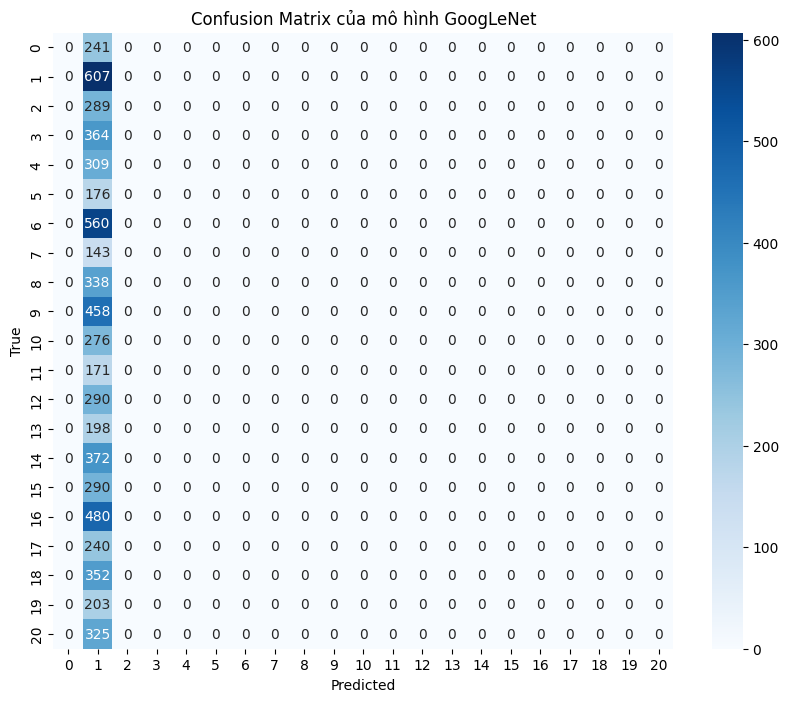


Đang vẽ biểu đồ Loss và Accuracy...


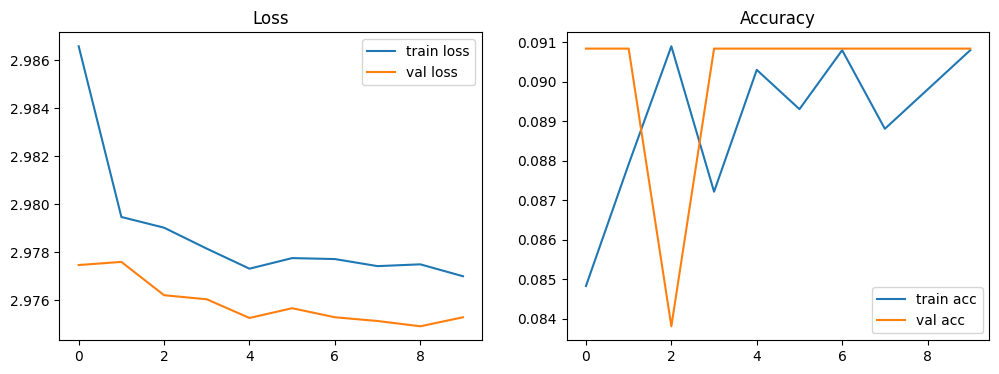

<Figure size 640x480 with 0 Axes>

In [6]:
import sys
sys.path.insert(0, '/kaggle/working/dl')
%run /kaggle/working/dl/main_googlenet.py